# Introduction

Useful links

* https://medium.datadriveninvestor.com/unet-for-semantic-segmentation-implementation-from-scratch-26e043fdcffa
* https://github.com/raoofnaushad/UNET_SALT_DETECTION
* https://keras.io/api/metrics/

## Connecting to the drive

In [33]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Importing libraries

In [34]:
!python --version

Python 3.10.12


In [35]:
import os
import numpy as np
import time
import gc #garbage collector
import random
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm #progress bar
from PIL import Image
from datetime import datetime
from skimage.transform import resize

from sklearn.model_selection import train_test_split, KFold, StratifiedKFold

from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Accuracy, Precision, Recall, SensitivityAtSpecificity, SpecificityAtSensitivity, MeanIoU
from tensorflow.keras import Model, backend as K
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPooling2D, Conv2DTranspose, concatenate, Input, Dropout
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img
from tensorflow.keras.utils import plot_model

## Configurations

### Environment variables

In [36]:
TASK = 1

os.environ["DATASET_PATH"] = "/content/drive/MyDrive/skin_cancer/assets/numpy_dataset/"

if TASK == 1:
  os.environ["TASK"] = "task_1_lesion_segmentation"
  os.environ["NUMBER_OF_CLASSES"] = "1"

  os.environ["TRAINING_MASKS_PATH"] = str(os.environ["DATASET_PATH"] + "ISIC2018_Task1_Training_GroundTruth")
  os.environ["VALIDATION_MASKS_PATH"] = str(os.environ["DATASET_PATH"] + "ISIC2018_Task1_Validation_GroundTruth")
  os.environ["TEST_MASKS_PATH"] = str(os.environ["DATASET_PATH"] +  "ISIC2018_Task1_Test_GroundTruth")
elif TASK == 2:
  os.environ["TASK"] = "task_2_lesion_attribute_detection"
  os.environ["NUMBER_OF_CLASSES"] = "5"

  os.environ["TRAINING_MASKS_PATH"] = str(os.environ["DATASET_PATH"] + "ISIC2018_Task2_Training_GroundTruth_v3")
  os.environ["VALIDATION_MASKS_PATH"] = str(os.environ["DATASET_PATH"] + "ISIC2018_Task2_Validation_GroundTruth")
  os.environ["TEST_MASKS_PATH"] = str(os.environ["DATASET_PATH"] + "ISIC2018_Task2_Test_GroundTruth")

if TASK in [1, 2]:
  os.environ["TRAINING_IMAGES_PATH"] = str(os.environ["DATASET_PATH"] + "ISIC2018_Task1-2_Training_Input")
  os.environ["VALIDATION_IMAGES_PATH"] = str(os.environ["DATASET_PATH"] + "ISIC2018_Task1-2_Validation_Input")
  os.environ["TEST_IMAGES_PATH"] = str(os.environ["DATASET_PATH"] + "ISIC2018_Task1_and_2_Test_Input")

  # os.environ["VALIDATION_COUNT"] = "100"
  # os.environ["TRAINING_COUNT"] = "2594"
  # os.environ["TEST_COUNT"] = "1000"

  # os.environ["VALIDATION_COUNT"] = "50"
  # os.environ["TRAINING_COUNT"] = "500"
  # os.environ["TEST_COUNT"] = "50"

### Global variables

In [37]:
IM_HEIGHT = 256
IM_WIDTH = 256

# Data preparation

## Loading images

In [38]:
#Loading converted images into arrays

TRAINING_IMAGES = np.load(os.environ["TRAINING_IMAGES_PATH"] + "/ISIC2018_Task1-2_Training_Input.npy")
TRAINING_MASKS = np.load(os.environ["TRAINING_MASKS_PATH"] + "/ISIC2018_Task1_Training_GroundTruth.npy")

VALIDATION_IMAGES = np.load(os.environ["VALIDATION_IMAGES_PATH"] + "/ISIC2018_Task1-2_Validation_Input.npy")
VALIDATION_MASKS = np.load(os.environ["VALIDATION_MASKS_PATH"] + "/ISIC2018_Task1_Validation_GroundTruth.npy")


TRAINING_IMAGES = TRAINING_IMAGES[:1523]
TRAINING_MASKS = TRAINING_MASKS[:1523]
VALIDATION_IMAGES = VALIDATION_IMAGES[:73]
VALIDATION_MASKS = VALIDATION_MASKS[:73]

print(f"No of images in the training - TRAINING_IMAGES: {len(TRAINING_IMAGES)} y: {len(TRAINING_MASKS)}")
print(f"No of images in the validation - x: {len(VALIDATION_IMAGES)} y: {len(VALIDATION_MASKS)}")

No of images in the training - TRAINING_IMAGES: 1523 y: 1523
No of images in the validation - x: 73 y: 73


## Plotting image

Random Sample Index is: 44


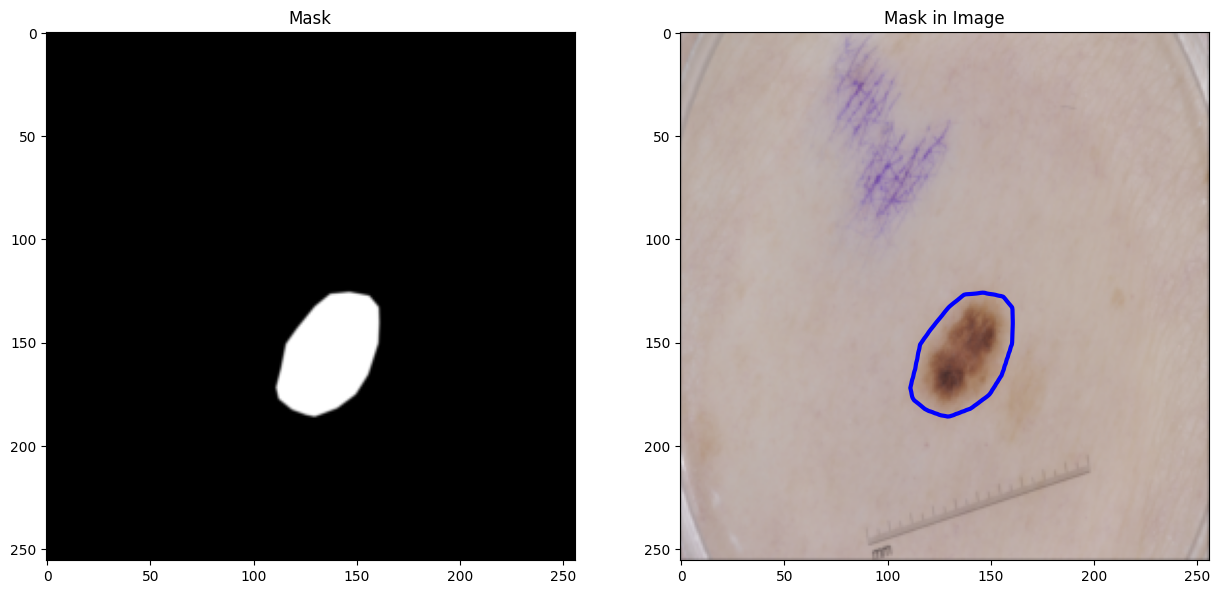

In [39]:
## Plotting Sample Data

def plot_sample_example():
    ix = random.randint(0, len(TRAINING_IMAGES))
    print(f"Random Sample Index is: {ix}")
    has_mask = TRAINING_MASKS[ix].max() > 0

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 10))

    ax1.imshow(TRAINING_MASKS[ix].squeeze(), cmap = 'gray', interpolation = 'bilinear')
    ax1.set_title('Mask')

    ax2.imshow((TRAINING_IMAGES[ix]).squeeze())

    if has_mask:
        ax2.contour(TRAINING_MASKS[ix].squeeze(), colors = 'blue', linewidths = 3, levels = [0.5])
    ax2.set_title('Mask in Image')

plot_sample_example()

# Model

## Defining the model (U-net)

In [40]:
## 2D two Convolution layer block
def Conv2D_block(input_tensor, n_filters, kernel_size, batchnorm): #Function to add 2 convolutional layers
    #Convolution layer - 1
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer='he_normal', padding='same')(input_tensor)
    #batchnormalization
    if batchnorm:
        x = BatchNormalization()(x)
    #Activation
    x = Activation('relu')(x)

    #Convolution layer - 2
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer='he_normal', padding='same')(x)
    #batchnormalization
    if batchnorm:
        x = BatchNormalization()(x)
    #Activation
    x = Activation('relu')(x)

    return x

In [41]:
#Unet Architecture
def unet(input_image, n_filters=16, kernel_size=3, dropout=0.1, batchnorm=False):
    #Encoder Path || Contractor Path
    c1 = Conv2D_block(input_image, n_filters, kernel_size = kernel_size, batchnorm = batchnorm)
    p1 = MaxPooling2D((2,2))(c1)
    # p1 = Dropout(dropout)(p1)

    c2 = Conv2D_block(p1, n_filters * 2, kernel_size = kernel_size, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    # p2 = Dropout(dropout)(p2)

    c3 = Conv2D_block(p2, n_filters * 4, kernel_size = kernel_size, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    # p3 = Dropout(dropout)(p3)

    c4 = Conv2D_block(p3, n_filters * 8, kernel_size = kernel_size, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    # p4 = Dropout(dropout)(p4)

    c5 = Conv2D_block(p4, n_filters * 16, kernel_size = kernel_size, batchnorm = batchnorm)


    #Decoder Path  || Expansion Path
    u6 = Conv2DTranspose(n_filters * 8, (kernel_size, kernel_size), strides=(2,2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    # u6 = Dropout(dropout)(u6)
    c6 = Conv2D_block(u6, n_filters * 8, kernel_size = kernel_size, batchnorm = batchnorm)

    u7 = Conv2DTranspose(n_filters * 4, (kernel_size, kernel_size), strides=(2,2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    # u7 = Dropout(dropout)(u7)
    c7 = Conv2D_block(u7, n_filters * 4, kernel_size = kernel_size, batchnorm = batchnorm)

    u8 = Conv2DTranspose(n_filters * 2, (kernel_size, kernel_size), strides=(2,2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    # u8 = Dropout(dropout)(u8)
    c8 = Conv2D_block(u8, n_filters * 2, kernel_size = kernel_size, batchnorm = batchnorm)

    u9 = Conv2DTranspose(n_filters, (kernel_size, kernel_size), strides=(2,2), padding='same')(c8)
    u9 = concatenate([u9, c1])
    # u9 = Dropout(dropout)(u9)
    c9 = Conv2D_block(u9, n_filters, kernel_size = kernel_size, batchnorm = batchnorm)

    #final 1*1 Convolutional layer
    output = Conv2D(1, (1,1), activation='sigmoid')(c9)
    model = Model(inputs=[input_image], outputs=[output])
    return model

## Defining the model (improved U-net)

In [42]:
## 2D two Convolution layer block
def improved_Conv2D_block(input_tensor, n_filters, conv_number, kernel_size=3, batchnorm=True): #Function to add 2 convolutional layers
    # Convolution layer
    for conv in range(conv_number):
      x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer='he_normal', padding='same', activation='relu')(input_tensor)
      if batchnorm:
        x = BatchNormalization()(x)
      input_tensor = x

    return x

In [43]:
#Unet Architecture
def improved_unet(input_image, n_filters=16, kernel_size=3, dropout=0.2, batchnorm=True):
    #Encoder Path || Contractor Path
    c1 = improved_Conv2D_block(input_image, n_filters, kernel_size = kernel_size, batchnorm = batchnorm, conv_number=1)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)

    c2 = improved_Conv2D_block(p1, (n_filters * 2), kernel_size = kernel_size, batchnorm = batchnorm, conv_number=2)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)

    c3 = improved_Conv2D_block(p2, (n_filters * 4), kernel_size = kernel_size, batchnorm = batchnorm, conv_number=2)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)

    c4 = improved_Conv2D_block(p3, (n_filters * 8), kernel_size = kernel_size, batchnorm = batchnorm, conv_number=3)

    #Decoder Path  || Expansion Path
    u5 = Conv2DTranspose((n_filters * 4), (kernel_size, kernel_size), strides=(2,2), padding='same')(c4)
    u5 = concatenate([u5, c3])
    u5 = Dropout(dropout)(u5)
    c5 = improved_Conv2D_block(u5, (n_filters * 4), kernel_size = kernel_size, batchnorm = batchnorm, conv_number=2)

    u6 = Conv2DTranspose((n_filters * 2), (kernel_size, kernel_size), strides=(2,2), padding='same')(c5)
    u6 = concatenate([u6, c2])
    u6 = Dropout(dropout)(u6)
    c6 = improved_Conv2D_block(u6, (n_filters * 2), kernel_size = kernel_size, batchnorm = batchnorm, conv_number=2)

    u7 = Conv2DTranspose(n_filters, (kernel_size, kernel_size), strides=(2,2), padding='same')(c6)
    u7 = concatenate([u7, c1])
    u7 = Dropout(dropout)(u7)

    c7 = improved_Conv2D_block(u7, n_filters, kernel_size = kernel_size, batchnorm = batchnorm, conv_number=1)

    #final 1*1 Convolutional layer
    output = Conv2D(1, (1,1), activation='sigmoid')(c7)
    model = Model(inputs=[input_image], outputs=[output])
    return model

## Defining the metrics

In [44]:
def dice_coef(y_true, y_pred, smooth=1):
  y_true_f = K.flatten(y_true)
  y_pred_f = K.flatten(y_pred)
  intersection = K.sum(y_true_f * y_pred_f)

  return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def iou(y_true, y_pred): #Jaccard
  y_true_f = K.flatten(y_true)
  y_pred_f = K.flatten(y_pred)
  intersection = K.sum(y_true_f * y_pred_f)
  union = K.sum(y_true_f) + K.sum(y_pred_f) - intersection

  return intersection/union

def specificity(y_true, y_pred):
  true_negatives = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
  possible_negatives = K.sum(K.round(K.clip(1 - y_true, 0, 1)))

  return true_negatives / (possible_negatives + K.epsilon())

# Training

In [45]:
#Instantiate Keras tensor
input_img = Input((IM_HEIGHT, IM_WIDTH, 3), name='img')
metrics=[Accuracy(), Precision(), Recall(), iou, specificity, dice_coef]

#initialize params
n_filters = 16 #32
kernel_size = 5
dropout = 0.1
batch_size = 16 #32
epochs = 20
optimizer = Adam()

#CallBacks
call_backs = [
    EarlyStopping(patience=10, verbose=1), #prevents overfitting or unnecessary training
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
    ModelCheckpoint(f'/content/drive/MyDrive/skin_cancer/models/unet/assets/unet13_drop_{n_filters}_{kernel_size}_{batch_size}_{epochs}.h5', verbose=1, save_best_only=True, save_weights_only=True) #saves the model
]

### Kfold

In [46]:
# #@title
# # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
# # kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=7) https://machinelearningmastery.com/evaluate-performance-deep-learning-models-keras/

# kf = KFold(n_splits = 5)

# loss_scores = []
# precision_scores = []
# iou_scores = []
# recall_scores = []
# specificity_score = []
# dice_coef_scores = []

# for train_idx, val_idx in list(kf.split(TRAINING_IMAGES, TRAINING_MASKS)):
#   X_train, X_val = TRAINING_IMAGES[train_idx], TRAINING_IMAGES[val_idx]
#   y_train, y_val = TRAINING_MASKS[train_idx], TRAINING_MASKS[val_idx]

#   # create model
#   model = unet(input_img, n_filters=n_filters, kernel_size=kernel_size, dropout=dropout, batchnorm=True)

#   # Compile model
#   model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=metrics)

#   # Fit the model
#   results = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, callbacks=call_backs, validation_data=(X_val, y_val))

#   loss = (results.history['loss'][-1])
#   precision = (results.history['precision'][-1])
#   recall = (results.history['recall'][-1])
#   iou = (results.history['iou'][-1])
#   specificity = (results.history['specificity'][-1])
#   dice_coef = (results.history['dice_coef'][-1])

#   print(f"loss: {loss}")
#   print(f"precision: {precision}")
#   print(f"recall: {recall}")
#   print(f"iou: {iou}")
#   print(f"specificity: {specificity}")
#   print(f"dice_coef: {dice_coef}")

#   loss_scores.append(loss)
#   precision_scores.append(precision)
#   recall_scores.append(recall)
#   iou_scores.append(iou)
#   specificity_score.append(specificity)
#   dice_coef_scores.append(dice_coef)

#   K.clear_session()
#   gc.collect()

#   del model
#   del X_train
#   del X_val
#   del y_train
#   del y_val
#   del results
#   del train_idx
#   del val_idx

# print(f"{np.mean(loss_scores)} (+/- {np.std(loss_scores)})")
# print(f"{np.mean(precision_scores)} (+/- {np.std(precision_scores)})")
# print(f"{np.mean(recall_scores)} (+/- {np.std(recall_scores)})")
# print(f"{np.mean(iou_scores)} (+/- {np.std(iou_scores)})")
# print(f"{np.mean(specificity_score)} (+/- {np.std(specificity_score)})")
# print(f"{np.mean(dice_coef_scores)} (+/- {np.std(dice_coef_scores)})")

### train_test_split

In [47]:
X_train, X_val, y_train, y_val = train_test_split(TRAINING_IMAGES, TRAINING_MASKS, test_size=0.2)

start = datetime.now()

# create model
model = unet(input_img, n_filters=n_filters, kernel_size=kernel_size, dropout=dropout)

# Compile model
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=metrics)

# Fit the model
results = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, callbacks=call_backs, validation_data=(X_val, y_val))

K.clear_session()
gc.collect()

print(f"time: {datetime.now() - start}")

Epoch 1/20
77/77 [==============================] - ETA: 0s - loss: 0.4305 - accuracy: 0.0000e+00 - precision: 0.7611 - recall: 0.1446 - iou: 0.1866 - specificity: 0.9847 - dice_coef: 0.3119
Epoch 1: val_loss improved from inf to 0.43351, saving model to /content/drive/MyDrive/skin_cancer/models/unet/assets/unet13_drop_16_5_16_20.h5
77/77 [==============================] - 31s 294ms/step - loss: 0.4305 - accuracy: 0.0000e+00 - precision: 0.7611 - recall: 0.1446 - iou: 0.1866 - specificity: 0.9847 - dice_coef: 0.3119 - val_loss: 0.4335 - val_accuracy: 0.0000e+00 - val_precision: 0.9526 - val_recall: 0.1969 - val_iou: 0.2150 - val_specificity: 0.9961 - val_dice_coef: 0.3514 - lr: 0.0010
Epoch 2/20
77/77 [==============================] - ETA: 0s - loss: 0.4016 - accuracy: 1.2528e-08 - precision: 0.7830 - recall: 0.2875 - iou: 0.2187 - specificity: 0.9735 - dice_coef: 0.3572
Epoch 2: val_loss improved from 0.43351 to 0.41064, saving model to /content/drive/MyDrive/skin_cancer/models/unet/

In [48]:
K.clear_session()
gc.collect()

6048

# Results

## U-net

[0.18660512566566467, 0.21869131922721863, 0.2329455316066742, 0.279106080532074, 0.28578001260757446, 0.3236719071865082, 0.3576415777206421, 0.3670685887336731, 0.38217639923095703, 0.3341188430786133, 0.395914226770401, 0.4136893153190613, 0.3961649537086487, 0.45612800121307373, 0.4692734181880951, 0.4791470766067505, 0.48805391788482666, 0.4948437809944153, 0.5035473108291626, 0.5024038553237915]


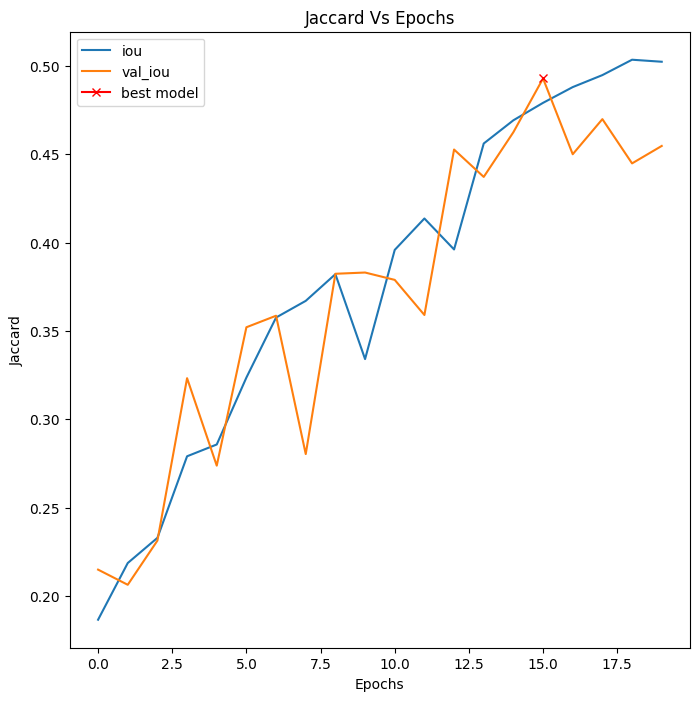

In [49]:
#Unet Jaccard
def plot_history(results):
    plt.figure(figsize=(8,8))
    plt.title("Jaccard Vs Epochs")
    plt.plot(results.history["iou"], label="iou")
    plt.plot(results.history["val_iou"], label="val_iou")
    plt.plot( np.argmax(results.history["val_iou"]), np.max(results.history["val_iou"]), marker="x", color="r", label="best model")
    plt.xlabel("Epochs")
    plt.ylabel("Jaccard")
    plt.legend()

plot_history(results)
print(results.history["iou"])

[0.4305034577846527, 0.4015837013721466, 0.38789090514183044, 0.3607361614704132, 0.3559914827346802, 0.3336164355278015, 0.31398648023605347, 0.31086018681526184, 0.3006015121936798, 0.31953343749046326, 0.2923082709312439, 0.27856189012527466, 0.2820158302783966, 0.24864622950553894, 0.2401846945285797, 0.23418115079402924, 0.22931839525699615, 0.2227332442998886, 0.21894969046115875, 0.21937626600265503]


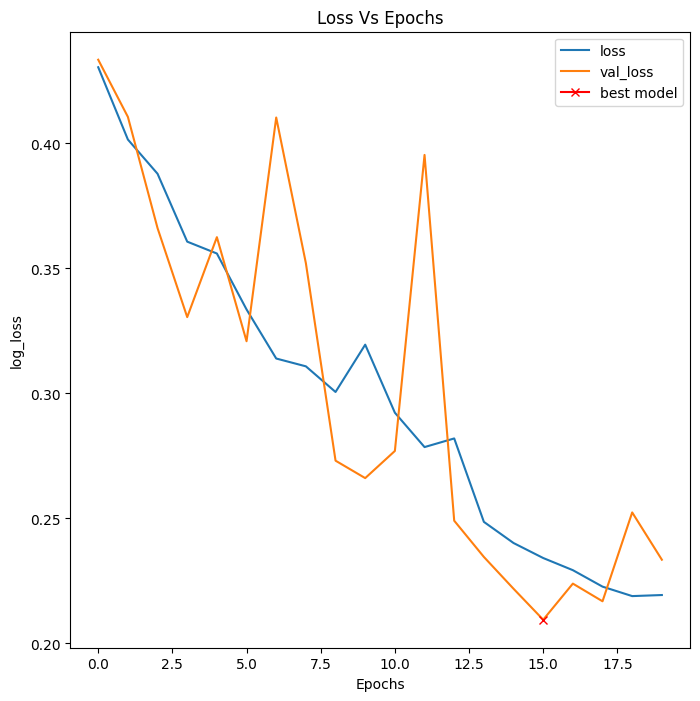

In [50]:
#Unet loss
def plot_history(results):
    plt.figure(figsize=(8,8))
    plt.title("Loss Vs Epochs")
    plt.plot(results.history["loss"], label="loss")
    plt.plot(results.history["val_loss"], label="val_loss")
    plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
    plt.xlabel("Epochs")
    plt.ylabel("log_loss")
    plt.legend()

plot_history(results)
print(results.history["loss"])

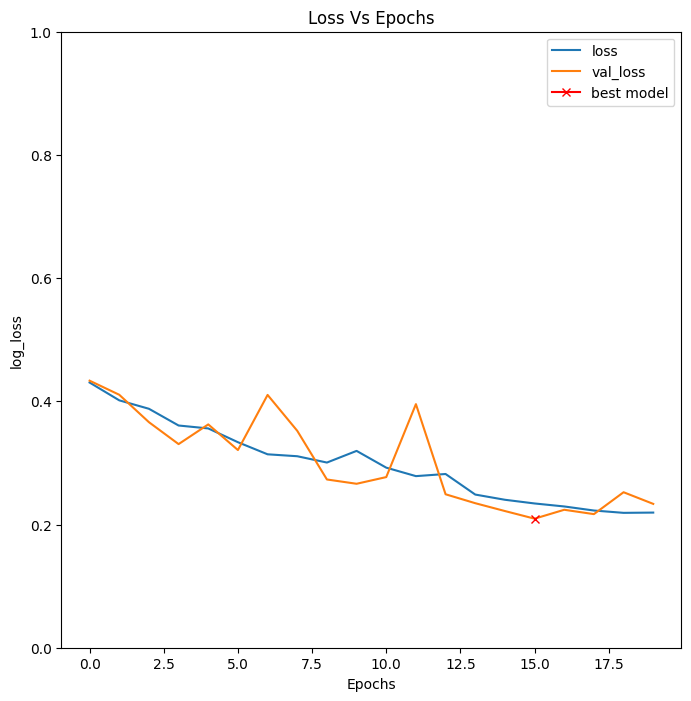

In [51]:
#Unet loss
def plot_history(results):
    plt.figure(figsize=(8,8))
    plt.title("Loss Vs Epochs")
    plt.plot(results.history["loss"], label="loss")
    plt.plot(results.history["val_loss"], label="val_loss")
    plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
    plt.ylim([0, 1])
    plt.xlabel("Epochs")
    plt.ylabel("log_loss")
    plt.legend()

plot_history(results)

[0.7610901594161987, 0.7829695343971252, 0.7922191619873047, 0.8494108319282532, 0.838977038860321, 0.8717492818832397, 0.8853996992111206, 0.8865422010421753, 0.9048091769218445, 0.9018028974533081, 0.8873249888420105, 0.8920214176177979, 0.8916221261024475, 0.907177209854126, 0.9116137623786926, 0.908509373664856, 0.9116621613502502, 0.9222326278686523, 0.912215530872345, 0.9202718138694763]


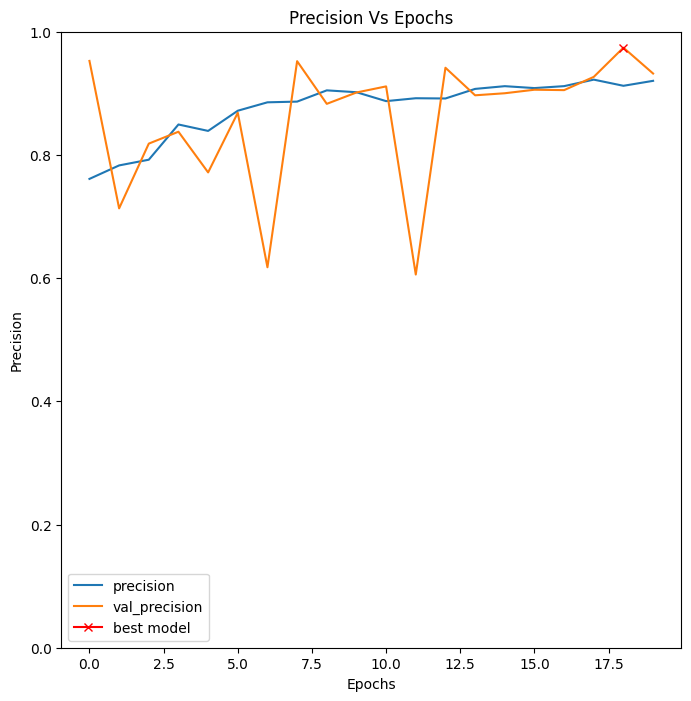

In [52]:
#Unet Precision
def plot_history(results):
    plt.figure(figsize=(8,8))
    plt.title("Precision Vs Epochs")
    plt.plot(results.history["precision"], label="precision")
    plt.plot(results.history["val_precision"], label="val_precision")
    plt.plot(np.argmax(results.history["val_precision"]), np.max(results.history["val_precision"]), marker="x", color="r", label="best model")
    plt.ylim([0, 1])
    plt.xlabel("Epochs")
    plt.ylabel("Precision")
    plt.legend()

plot_history(results)
print(results.history["precision"])

[0.9846764802932739, 0.973534345626831, 0.9653794765472412, 0.975090742111206, 0.9729865193367004, 0.9746702909469604, 0.9754299521446228, 0.9752196073532104, 0.978479266166687, 0.9802061915397644, 0.9732236862182617, 0.9725509285926819, 0.9740419983863831, 0.9739490151405334, 0.9755111336708069, 0.9740031957626343, 0.9740305542945862, 0.9765629172325134, 0.9735836386680603, 0.9764293432235718]


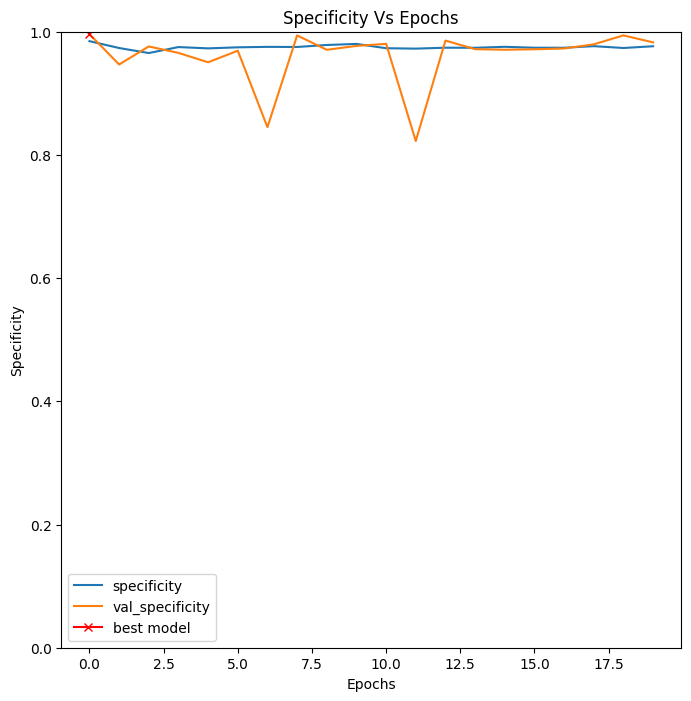

In [53]:
# Unet Specificity
def plot_history(results):
    plt.figure(figsize=(8,8))
    plt.title("Specificity Vs Epochs")
    plt.plot(results.history["specificity"], label="specificity")
    plt.plot(results.history["val_specificity"], label="val_specificity")
    plt.plot(np.argmax(results.history["val_specificity"]), np.max(results.history["val_specificity"]), marker="x", color="r", label="best model")
    plt.ylim([0, 1])
    plt.xlabel("Epochs")
    plt.ylabel("Specificity")
    plt.legend()

plot_history(results)
print(results.history["specificity"])

[0.3118720054626465, 0.3572087585926056, 0.37566256523132324, 0.43244224786758423, 0.4400930404663086, 0.4865086078643799, 0.5237888693809509, 0.5340055823326111, 0.5500608682632446, 0.4973277747631073, 0.5654823780059814, 0.5831612348556519, 0.5643770694732666, 0.6236365437507629, 0.6371015310287476, 0.6461337804794312, 0.6545140743255615, 0.6607311367988586, 0.6685698628425598, 0.6671751737594604]


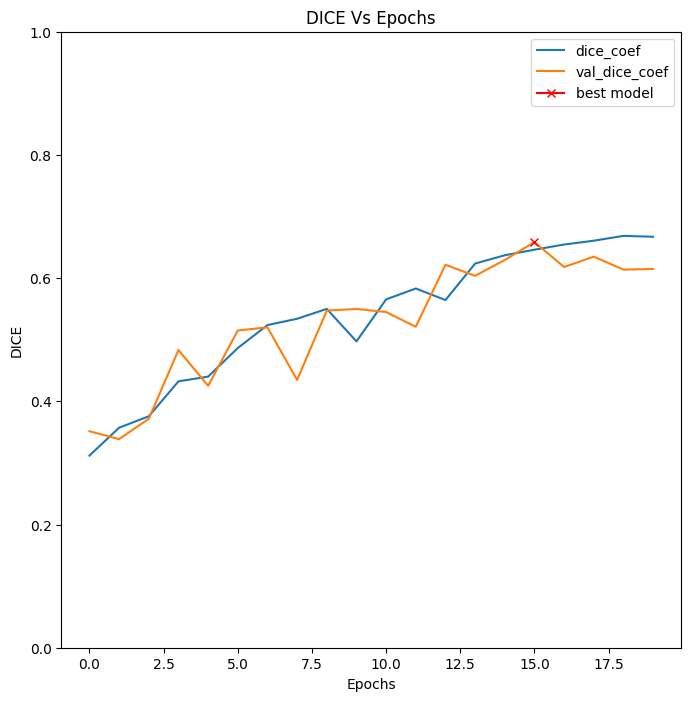

In [54]:
#Unet DICE
def plot_history(results):
    plt.figure(figsize=(8,8))
    plt.title("DICE Vs Epochs")
    plt.plot(results.history["dice_coef"], label="dice_coef")
    plt.plot(results.history["val_dice_coef"], label="val_dice_coef")
    plt.plot(np.argmax(results.history["val_dice_coef"]), np.max(results.history["val_dice_coef"]), marker="x", color="r", label="best model")
    plt.ylim([0, 1])
    plt.xlabel("Epochs")
    plt.ylabel("DICE")
    plt.legend()

plot_history(results)
print(results.history["dice_coef"])

[0.14456714689731598, 0.2874666750431061, 0.35674577951431274, 0.4162798821926117, 0.42454439401626587, 0.4942781925201416, 0.5525519251823425, 0.5590908527374268, 0.5746632218360901, 0.4959486424922943, 0.6080489754676819, 0.6389385461807251, 0.602118730545044, 0.6911337971687317, 0.6995231509208679, 0.7107475996017456, 0.7317459583282471, 0.7317582368850708, 0.7450653314590454, 0.7348492741584778]


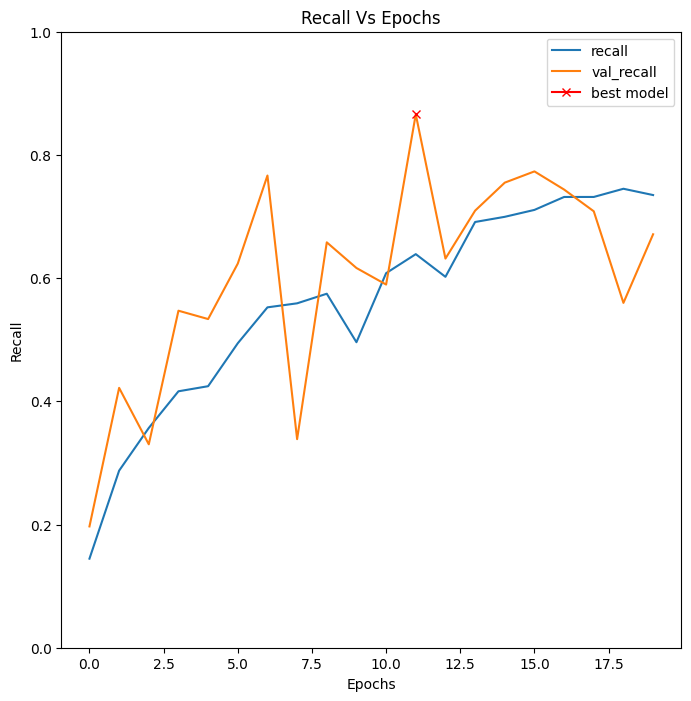

In [55]:
#Unet Recall
def plot_history(results):
    plt.figure(figsize=(8,8))
    plt.title("Recall Vs Epochs")
    plt.plot(results.history["recall"], label="recall")
    plt.plot(results.history["val_recall"], label="val_recall")
    plt.plot(np.argmax(results.history["val_recall"]), np.max(results.history["val_recall"]), marker="x", color="r", label="best model")
    plt.ylim([0, 1])
    plt.xlabel("Epochs")
    plt.ylabel("Recall")
    plt.legend()

plot_history(results)
print(results.history["recall"])

In [56]:
model.evaluate(VALIDATION_IMAGES, VALIDATION_MASKS, verbose=1)

3/3 [==============================] - 3s 1s/step - loss: 0.2989 - accuracy: 0.0000e+00 - precision: 0.9580 - recall: 0.6517 - iou: 0.4627 - specificity: 0.9853 - dice_coef: 0.6301


[0.2988698184490204,
 0.0,
 0.958021342754364,
 0.6517441272735596,
 0.46265020966529846,
 0.9853389859199524,
 0.6300885677337646]

In [57]:
np.sum([np.prod(v.get_shape().as_list()) for v in model.trainable_variables])

5993329

In [58]:
preds_val = model.predict(VALIDATION_IMAGES, verbose=1)
preds_val_t = (preds_val > 0.5).astype(np.uint8)

3/3 [==============================] - 1s 112ms/step


In [59]:
def plot_sample_results(X, y, preds, binary_preds, has_mask):
    ix = random.randint(0, len(X))
    print(ix)

    fig, ax = plt.subplots(1, 4, figsize=(20,10))

    ax[0].imshow(X[ix])
    if has_mask:
        ax[0].contour(y[ix].squeeze(), colors='b', levels=[0.5])
    ax[0].set_title('real mask')

    ax[1].imshow(preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[1].contour(y[ix].squeeze(), colors='b', levels=[0.5])
    ax[1].set_title('cancer Predicted')

    ax[2].imshow(binary_preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[2].contour(y[ix].squeeze(), colors='b', levels=[0.5])
    ax[2].set_title('cancer Predicted Binary')

    ax[3].imshow(X[ix])
    if has_mask:
        ax[3].contour(y[ix].squeeze(), colors='b', levels=[0.5])
    ax[3].contour(binary_preds[ix].squeeze(), colors='y', levels=[0.5])
    ax[3].set_title('cancer')

51


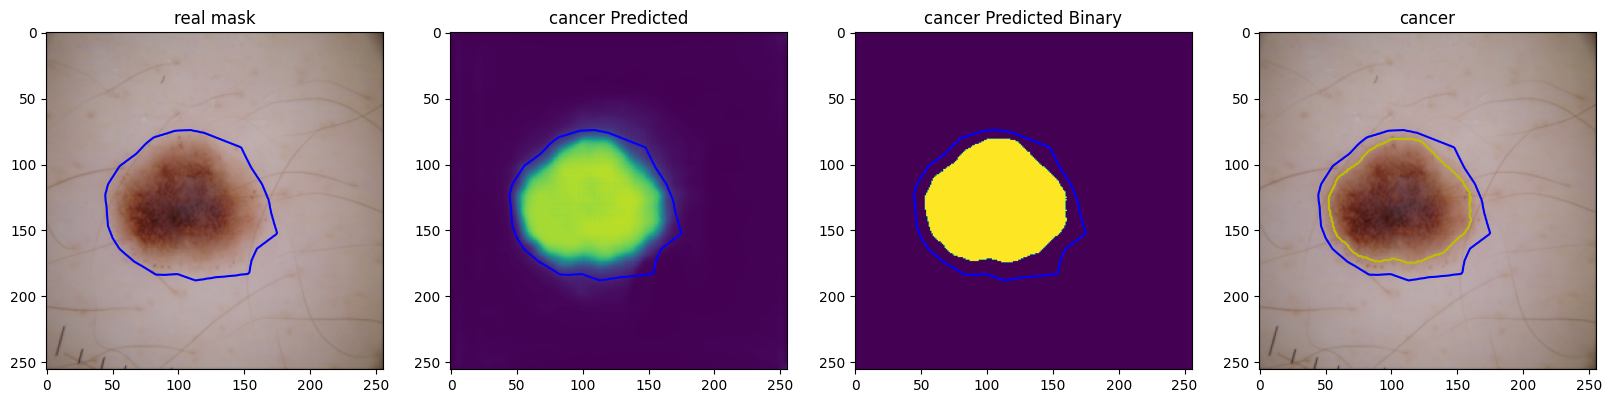

In [60]:
## Predictions on Test Set 62
plot_sample_results(X=VALIDATION_IMAGES, y=VALIDATION_MASKS, preds=preds_val, binary_preds=preds_val_t, has_mask=True)

18


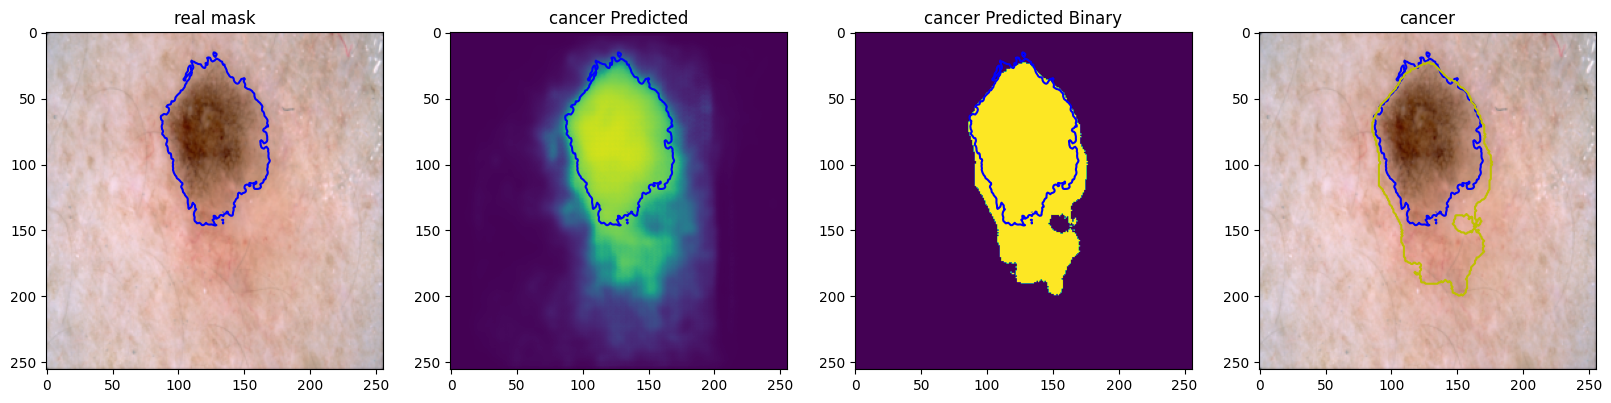

In [61]:
plot_sample_results(X=VALIDATION_IMAGES, y=VALIDATION_MASKS, preds=preds_val, binary_preds=preds_val_t, has_mask=True)

31


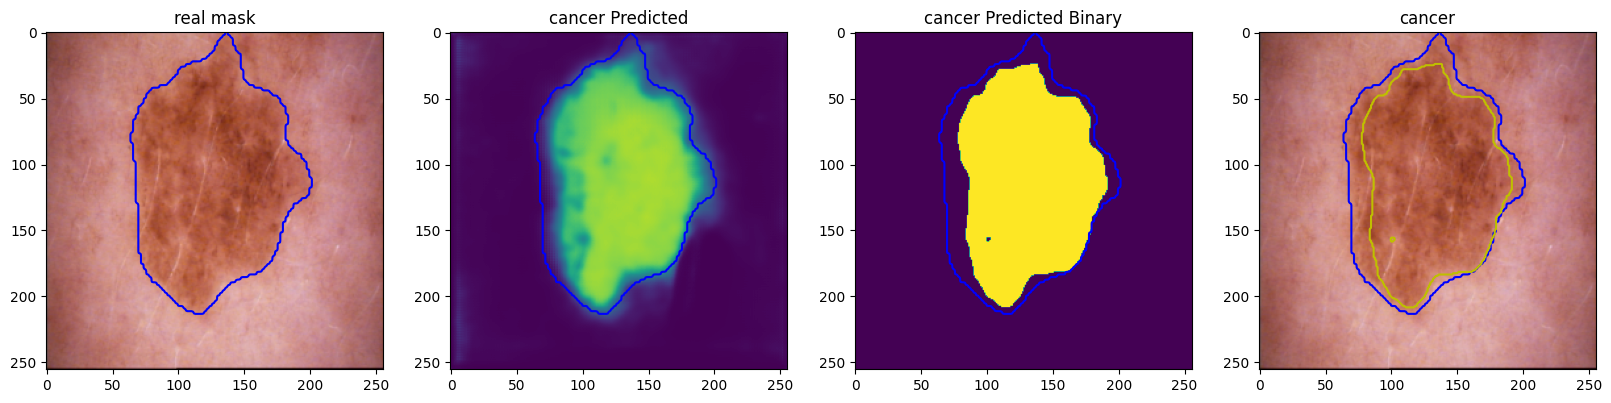

In [62]:
## Predictions on Test Set 40
plot_sample_results(X=VALIDATION_IMAGES, y=VALIDATION_MASKS, preds=preds_val, binary_preds=preds_val_t, has_mask=True)

10


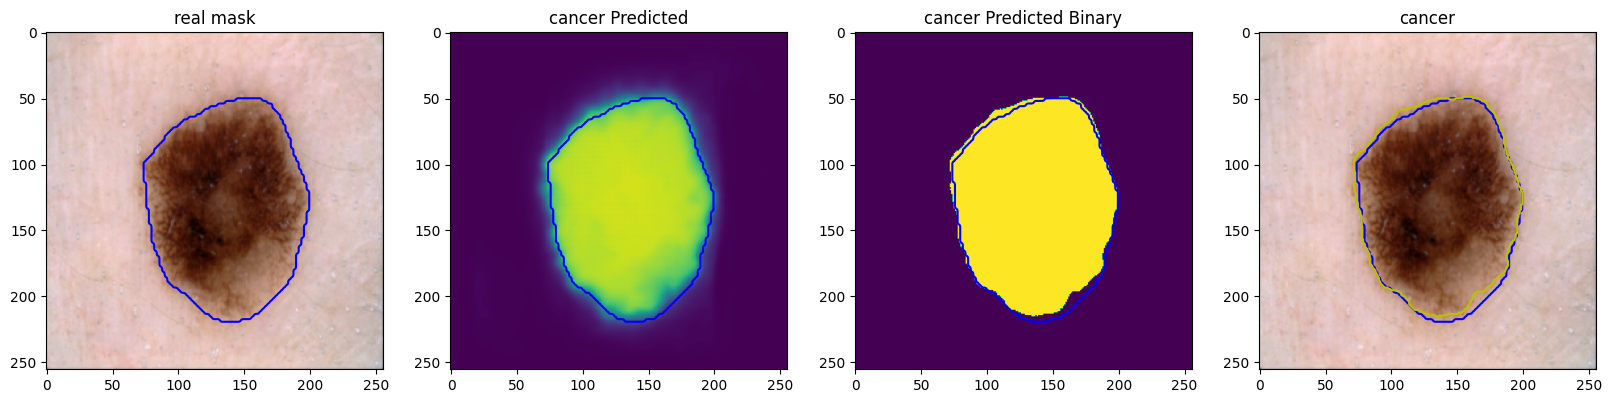

In [63]:
plot_sample_results(X=VALIDATION_IMAGES, y=VALIDATION_MASKS, preds=preds_val, binary_preds=preds_val_t, has_mask=True)

42


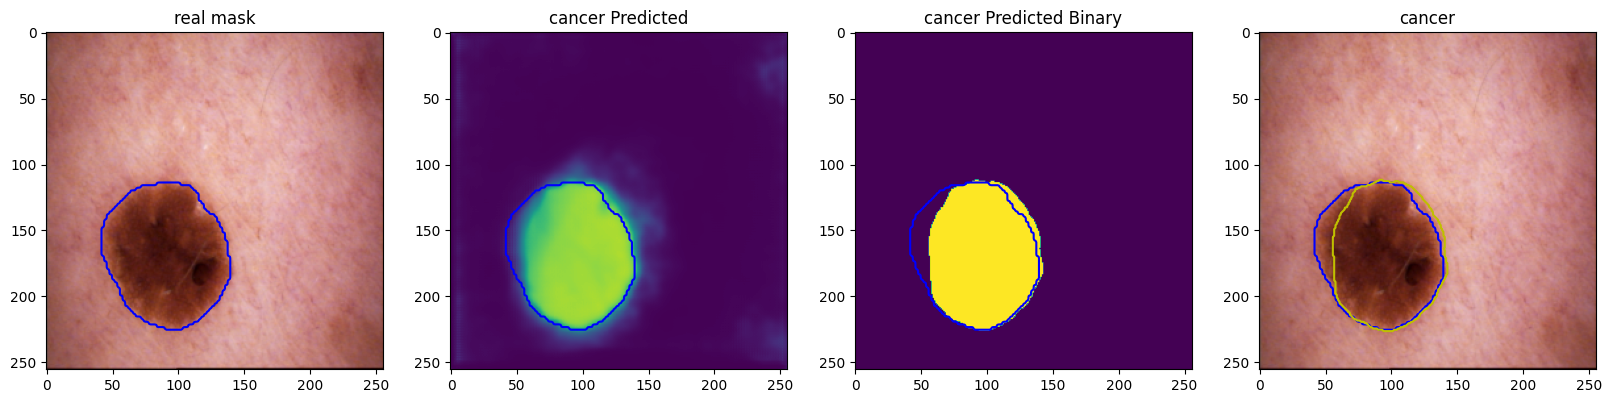

In [64]:
plot_sample_results(X=VALIDATION_IMAGES, y=VALIDATION_MASKS, preds=preds_val, binary_preds=preds_val_t, has_mask=True)